## Install packages

In [1]:
%%capture
%pip install --upgrade transformers
%pip install wget
%pip install -U git+https://github.com/huggingface/transformers.git
%pip install -U git+https://github.com/huggingface/accelerate.git

## Load packages

In [2]:
import json, os, wget, tarfile, zipfile, requests, wandb, torch, optuna
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from optuna.samplers import TPESampler
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import BlipProcessor, BlipForQuestionAnswering
from transformers import ViltConfig, ViltForQuestionAnswering, ViltProcessor
from transformers.tokenization_utils_base import BatchEncoding
import pandas as pd, numpy as np, torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from sklearn.utils import shuffle
from torch.optim import AdamW
from torch.nn import DataParallel
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm
import PIL, torchvision, random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")
from PIL import ImageOps


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Torch version: 2.0.0
Torchvision version: 0.15.1


## Download functions

The functions `download_and_extract()` and `download_and_extract_tar()` are used to download and extract compressed data files. 

In [4]:
def download_and_extract(data_url, zip_path):
    wget.download(data_url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()

def download_and_extract_tar(data_url, tar_path):
    wget.download(data_url, tar_path)
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall()

In [5]:
# # ---------------------------------------------#
# # Data from: https://visualqa.org/download.html
# # ---------------------------------------------#

# # Download and extract the training images
# download_and_extract("https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/scene_img/scene_img_abstract_v002_binary_train2017.zip",
#                      "scene_img_abstract_v002_binary_train2017.zip")

# # Download the training questions
# download_and_extract("https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Questions_Binary_Train2017_abstract_v002.zip",
#                      "Questions_Binary_Train2017_abstract_v002.zip")

# # Download the training annotations
# download_and_extract("https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Annotations_Binary_Train2017_abstract_v002.zip",
#                      "Annotations_Binary_Train2017_abstract_v002.zip")

# # Download and extract the validation images
# download_and_extract("https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/scene_img/scene_img_abstract_v002_binary_val2017.zip",
#                      "scene_img_abstract_v002_binary_val2017.zip")

# # Download the validation questions
# download_and_extract("https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Questions_Binary_Val2017_abstract_v002.zip",
#                      "Questions_Binary_Val2017_abstract_v002.zip")

# # Download the validation annotations
# download_and_extract("https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Annotations_Binary_Val2017_abstract_v002.zip",
#                      "Annotations_Binary_Val2017_abstract_v002.zip")

# ---------------------------------------------#
#          Validation Simpsons Data
# ---------------------------------------------#

# Download and extract the validation images
download_and_extract_tar("http://206.12.93.90:8080/simpson2022_dataset/simpsons_validation.tar.gz",
                     "simpsons_validation.tar.gz")

# Download the validation questions
download_and_extract("http://206.12.93.90:8080/simpson2022_dataset/questions_validation.zip",
                     "questions_validation.zip")

# Download the validation annotations
download_and_extract("http://206.12.93.90:8080/simpson2022_dataset/annotations_validation.zip",
                     "annotations_validation.zip")

# Filtering function 

From forked notebook - https://github.com/rbouadjenek/deakin-ai-challenge2023/blob/main/deakin_ai_challenge_tdeakin_ai_challenge_training.ipynb

In [6]:
def filter_questions(questions, annotations, answers, imgs_path, train_type, train):
    '''
    Filter questions for which the answers are not in the set of possible answers.
    '''
    
    answers = ['no','yes']
    num_answers = len(answers)
    
    # Make sure the questions and annotations are alligned
    questions['questions'] = sorted(questions['questions'], key=lambda x: x['question_id'])
    annotations['annotations'] = sorted(annotations['annotations'], key=lambda x: x['question_id'])
    q_out = []
    anno_out = []
    imgs_out = []
    q_ids = []
    question_ids_set = set()
    # Filter annotations
    for annotation in annotations['annotations']:
        if annotation['multiple_choice_answer'] in answers:
            question_ids_set.add(annotation['question_id'])
            q_ids.append(annotation['question_id'])
            anno_out.append(answers.index(annotation['multiple_choice_answer']))
    # Filter images and questions
    for q in questions['questions']:
        if q['question_id'] in question_ids_set:
            # Preprocessing the question
            q_text = q['question'].lower()
            q_text = q_text.replace('?', ' ? ')
            q_text = q_text.replace('.', ' . ')
            q_text = q_text.replace(',', ' . ')
            q_text = q_text.replace('!', ' . ').strip()
            q_out.append(q_text)
            file_name = str(q['image_id'])
            while len(file_name) != 12:
                file_name = '0' + file_name
            if train:
                file_name = imgs_path + questions['data_type'] + '_' + f"{train_type}2015" + '_' + file_name + '.png'
            else:
                file_name = imgs_path + questions['data_type'] + '_' + questions['data_subtype'] + '_' + file_name + '.png'
            imgs_out.append(file_name)
    return imgs_out, q_out, anno_out, q_ids

In [7]:
def preprocess_data(questions, annotations, image_paths, answers, train_type, train, shuffle_data=True):
    images, questions, annotations, question_ids = filter_questions(questions, annotations, answers, image_paths, train_type, train)
    if shuffle_data:
        images, questions, annotations, question_ids = shuffle(images, questions, annotations, question_ids, random_state=0)
    return images, questions, annotations, question_ids

In [33]:
# # Read training data
# q_train = json.load(open('/kaggle/input/binary-balanced-vqa/Questions_Binary_Train2017_abstract_v002/OpenEnded_abstract_v002_train2017_questions.json'))
# anno_train = json.load(open('/kaggle/input/binary-balanced-vqa/Annotations_Binary_Train2017_abstract_v002/abstract_v002_train2017_annotations.json'))
# imgs_train = "/kaggle/working/scene_img_abstract_v002_train2017/"

# Read validation data
q_val = json.load(open('/kaggle/working/questions_validation.json'))
anno_val = json.load(open('/kaggle/working/annotations_validation.json'))
imgs_val = "/kaggle/working/simpsons_validation/"

In [34]:
# # Training
# imgs_train, q_train, anno_train, q_ids_train = preprocess_data(q_train, anno_train, imgs_train, answers, 'train', train=True, shuffle_data=True)

# Validation
imgs_val, q_val, anno_val, q_ids_val = preprocess_data(q_val, anno_val, imgs_val, ['no','yes'], 'val', train=False, shuffle_data=False)

In [36]:
# Convert to numpy array 
imgs_val = np.array(imgs_val)
q_val = np.array(q_val)
anno_val = np.array(anno_val)

## Without Data Augmentation

In [15]:
class VQADatasetWithoutAugmentation(torch.utils.data.Dataset):
    def __init__(self, images, questions, annotations, processor):
        self.images = images
        self.questions = questions
        self.annotations = annotations
        self.processor = processor 

        self.transforms = transforms.Compose([
            transforms.Resize((256, 256)),
        ])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        img = self.transforms(img)
      
        encoding = self.processor(images=img, text=self.questions[idx], padding="max_length", truncation=True, return_tensors="pt")
        item = {key: val.squeeze() for key, val in encoding.items()}
        targets = torch.zeros(2) 
        targets[self.annotations[idx]] = 1
        item['labels'] = targets
        return item


## With Data Augmentation

In [16]:
class RandomApplyWithProb:
    """Applies a transformation with a certain probability."""
    def __init__(self, transform, probability=0.5):
        self.transform = transform
        self.probability = probability

    def __call__(self, x):
        return x if random.random() > self.probability else self.transform(x)

class MirrorFlip:
    """Applies a mirror flip (left-right reversal) to the image."""
    def __call__(self, img):
        return ImageOps.mirror(img)

class RandomApplyN:
    """Randomly select and apply N transformations from a list."""
    def __init__(self, transforms, n=2):
        self.transforms = transforms
        self.n = n

    def __call__(self, x):
        transforms_to_apply = random.sample(self.transforms, self.n)
        for transform in transforms_to_apply:
            x = transform(x)
        return x

class VQADataset(torch.utils.data.Dataset):
    def __init__(self, images, questions, annotations, processor):
        self.images = images
        self.questions = questions
        self.annotations = annotations
        self.processor = processor 

        transforms_list = [
            RandomApplyWithProb(MirrorFlip(), probability=0.5),
            RandomApplyWithProb(transforms.RandomCrop(224), probability=0.5),
            RandomApplyWithProb(transforms.RandomRotation(10), probability=0.5),
            RandomApplyWithProb(transforms.ColorJitter(brightness=0.2, contrast=0.2), probability=0.5),
            RandomApplyWithProb(transforms.RandomAffine(0, shear=(10,10)), probability=0.5),  
        ]
        
        self.transform = RandomApplyN(transforms_list, n=2)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        img = img.resize((256, 256))
        img = self.transform(img)

        encoding = self.processor(images=img, text=self.questions[idx], padding="max_length", truncation=True, return_tensors="pt")
        item = {key: val.squeeze() for key, val in encoding.items()}
        targets = torch.zeros(2) 
        targets[self.annotations[idx]] = 1
        item['labels'] = targets
        return item

## Other functions

In [17]:
def model_init():
    config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

    # Update the number of labels for binary classification
    config.num_labels = 2

    # Load the pre-trained model with the original configuration
    model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

    model.classifier = nn.Linear(config.hidden_size, config.num_labels)
 
    return model

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions
    
    # Convert one-hot encoded labels to indices
    labels_indices = labels.argmax(-1)
    
    # Compute the probability scores
    preds_prob = np.exp(preds) / np.sum(np.exp(preds), axis=-1, keepdims=True)
    
    acc = accuracy_score(labels_indices, preds.argmax(-1))
    
    # Calculate ROC AUC for multi-class
    roc_auc = roc_auc_score(labels, preds_prob, multi_class='ovr')
    
    return {
        'accuracy': acc,
        'roc_auc': roc_auc,
    }

## Load Pre-trained Model and Data for Training

In [ ]:
# # Load the existing configuration from the pre-trained model
# config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# # Update the number of labels for binary classification
# config.num_labels = 2

# # Load the pre-trained model with the original configuration
# model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# # Replace the classifier layer
# model.classifier = nn.Linear(config.hidden_size, config.num_labels)
# processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa") 

In [18]:
# Load base model again
wandb.init()
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa") 
path = wandb.use_artifact("usedpython/huggingface/deakin-ai-vilt-final:v3").download()
model = torch.load(path + "/model.pth", map_location=torch.device('cuda')) 

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact deakin-ai-vilt-final:v3, 425.93MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:7.1


In [19]:
def generate_new_train_subset(imgs_train, q_train, anno_train):
    train_indices = np.random.choice(len(imgs_train), size=len(q_train), replace=False)

    # Use these indices to create the new training subset
    subset_imgs = imgs_train[train_indices]
    subset_q = q_train[train_indices]
    subset_anno = anno_train[train_indices]

    # Create a new VQADataset with this subset
    train_subset = VQADatasetWithoutAugmentation(subset_imgs, subset_q, subset_anno, processor)

    return train_subset

In [ ]:
# # Convert to numpy array 
# imgs_train = np.array(imgs_train)
# q_train = np.array(q_train)
# anno_train = np.array(anno_train)

# # Training Model
# train_subset = generate_new_train_subset(imgs_train,q_train,anno_train)

In [ ]:
# # Set seed to ensure repeatability
# np.random.seed(42)

# # Convert to numpy array 
# imgs_val = np.array(imgs_val)
# q_val = np.array(q_val)
# anno_val = np.array(anno_val)

# # Validation Model
# val_indices = np.random.choice(len(imgs_val), size=1000, replace=False)
# val_imgs = imgs_val[val_indices]
# val_q = q_val[val_indices]
# val_anno = anno_val[val_indices]
# val_model = VQADatasetWithoutAugmentation(val_imgs, val_q, val_anno, processor)

## Load and pre-process data for further training then testing 

In [20]:
def read_file(file_path, csv=True):
    """Function to read a CSV or Excel file."""
    return pd.read_csv(file_path) if csv else pd.read_excel(file_path)

def update_image_paths(data, folder_path):
    """Function to update image paths in the given data using the specified folder path."""
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.endswith(".png"):
            image_id = int(filename.split("_")[-1].split(".")[0])
            if image_id in data['Image ID'].values:
                data.loc[data['Image ID'] == image_id, 'Image File'] = file_path

    for image_id in data['Image ID']:
        for ext in ['jpg', 'jpeg', 'png']:
            image_file = f"{image_id}.{ext}"
            image_path = os.path.join(folder_path, image_file)
            if os.path.isfile(image_path):
                data.loc[data['Image ID'] == image_id, 'Image File'] = image_path

    return data

def encode_labels(data):
    """Function to encode labels in the given data."""
    data['Answer'] = np.where(data['Answer'] == 'yes', 1, 0)
    return data

def pre_process(path, csv=True):
    """Function to pre-process data."""
    data = read_file(path, csv)
    data = update_image_paths(data, folder_path)
    data['Question'] = data['Question'].str.lower()
    data['Answer'] = data['Answer'].str.lower()
    data = encode_labels(data)
    data = data.dropna().reset_index(drop=True)
    return data

In [21]:
# # Define folder paths
# folder_path = "/kaggle/input/simp-data/Simpsons Train Data/Simpsons Train Data"
# folder_path_2 = "/kaggle/input/simp-data/simpsons_validation"

# # Load data
# train = pre_process('/kaggle/input/simp-data/train_data.csv',True)
# test = pre_process('/kaggle/input/simp-data/test_data.xlsx',False)

In [37]:
# # Training
# train_dataset = VQADataset(train['Image File'], train['Question'], train['Answer'], processor)
# eval_dataset = VQADatasetWithoutAugmentation(test['Image File'], test['Question'], test['Answer'], processor)

# Validation Model
val_model = VQADatasetWithoutAugmentation(imgs_val, q_val, anno_val, processor)

# Testing
test_dataloader = DataLoader(val_model, batch_size=1)

## Hyperparameter Search

In [ ]:
# def optuna_hp_space(trial):
#     return {
#         "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
#         "weight_decay": trial.suggest_loguniform("weight_decay", 1e-5, 1.0),
#     }

# # num_epochs = 4
# # num_training_samples = len(train_dataset)
# # num_training_steps = num_epochs * (num_training_samples // 64)
# # num_warmup_steps = int(0.1 * num_training_steps) 

# # lr_scheduler = get_linear_schedule_with_warmup(
# #     optimizer,
# #     num_warmup_steps=num_warmup_steps,
# #     num_training_steps=num_training_steps
# # )

# training_args = TrainingArguments(
#     num_train_epochs=1,  
#     output_dir="./results",
#     per_device_train_batch_size=64,  
#     per_device_eval_batch_size=32,  
#     warmup_steps=0,
#     remove_unused_columns=False,
#     report_to="wandb",
#     evaluation_strategy = "epoch",
#     load_best_model_at_end=False, 
#     metric_for_best_model="accuracy",
#     greater_is_better=True,
#     save_strategy="no", 
# )

# # Define the Trainer and launch the hyperparameter search
# trainer = Trainer(
#     model_init=model_init,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
# #     optimizers=(optimizer, scheduler),
#     compute_metrics=compute_metrics)

# # Use the created study for hyperparameter search
# best_run = trainer.hyperparameter_search(n_trials=20, 
#                                          direction="maximize", 
#                                          backend="optuna",
#                                          sampler=TPESampler(n_startup_trials=3),
#                                          hp_space=optuna_hp_space)

# # Output the best hyperparameters
# print(best_run) 

## Train Model

In [ ]:
# Best params for model
params = {'learning_rate': 4.809565038496718e-05, 'weight_decay': 0.07114166014493849}

In [ ]:
# Create optimizer
optimizer = AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

# Define training arguments
training_args = TrainingArguments(
    num_train_epochs=1,  
    output_dir=f"./results",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=16,
    remove_unused_columns=False,
    report_to="wandb",
    evaluation_strategy="epoch",
    load_best_model_at_end=False,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    learning_rate=params['learning_rate'],
    save_strategy="no", 
    weight_decay=params['weight_decay'],
    logging_steps=55,
    warmup_steps=10,
)

# Create the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

# Train the model
# trainer.train()

## Testing Model

In [38]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device) 
model.eval()

y_predict = []

with torch.no_grad():
    for local_batch in test_dataloader:
        local_batch = BatchEncoding(local_batch)
        local_batch.to(device)
        outputs = model(**local_batch)
        pred = outputs.logits.argmax(1)
        y_predict += pred.tolist()

y_predict = np.array(y_predict)

In [39]:
# Calculate accuracy
accuracy = accuracy_score(anno_val, y_predict)
print('Accuracy:', round(accuracy,3)*100)

Accuracy: 74.7


## Tune Threshold (roc auc)

In [40]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device) 
model.eval()

y_scores = []
y_true = []

# Run the model and collect scores and true labels
with torch.no_grad():
    for local_batch in test_dataloader:
        local_batch = BatchEncoding(local_batch)
        local_batch.to(device)
        outputs = model(**local_batch)

        probabilities = F.softmax(outputs.logits, dim=-1)
        y_scores += probabilities[:, 1].tolist()  
        
        # Convert multilabel-indicator y_true to binary
        y_true += [label[1] for label in local_batch['labels'].tolist()]

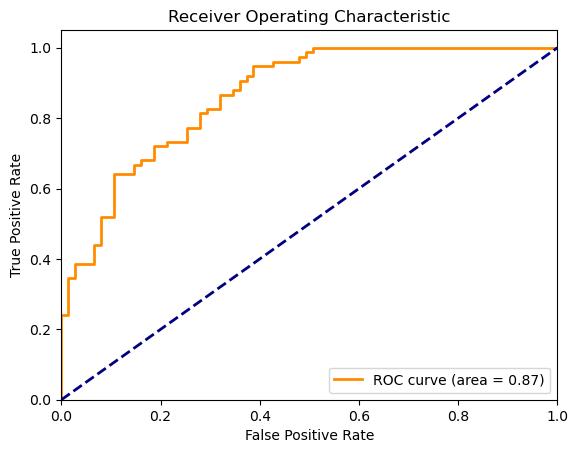

Optimal threshold: 0.8519659042358398


In [41]:
# Calculate the FPR, TPR, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calculate the ROC AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate the Euclidean distance for each point from the ideal point (0, 1) 
distances = np.sqrt((1-tpr)**2 + fpr**2)

# Find the optimal threshold
optimal_threshold = thresholds[np.argmin(distances)]
print(f'Optimal threshold: {optimal_threshold}')

## Error Analysis

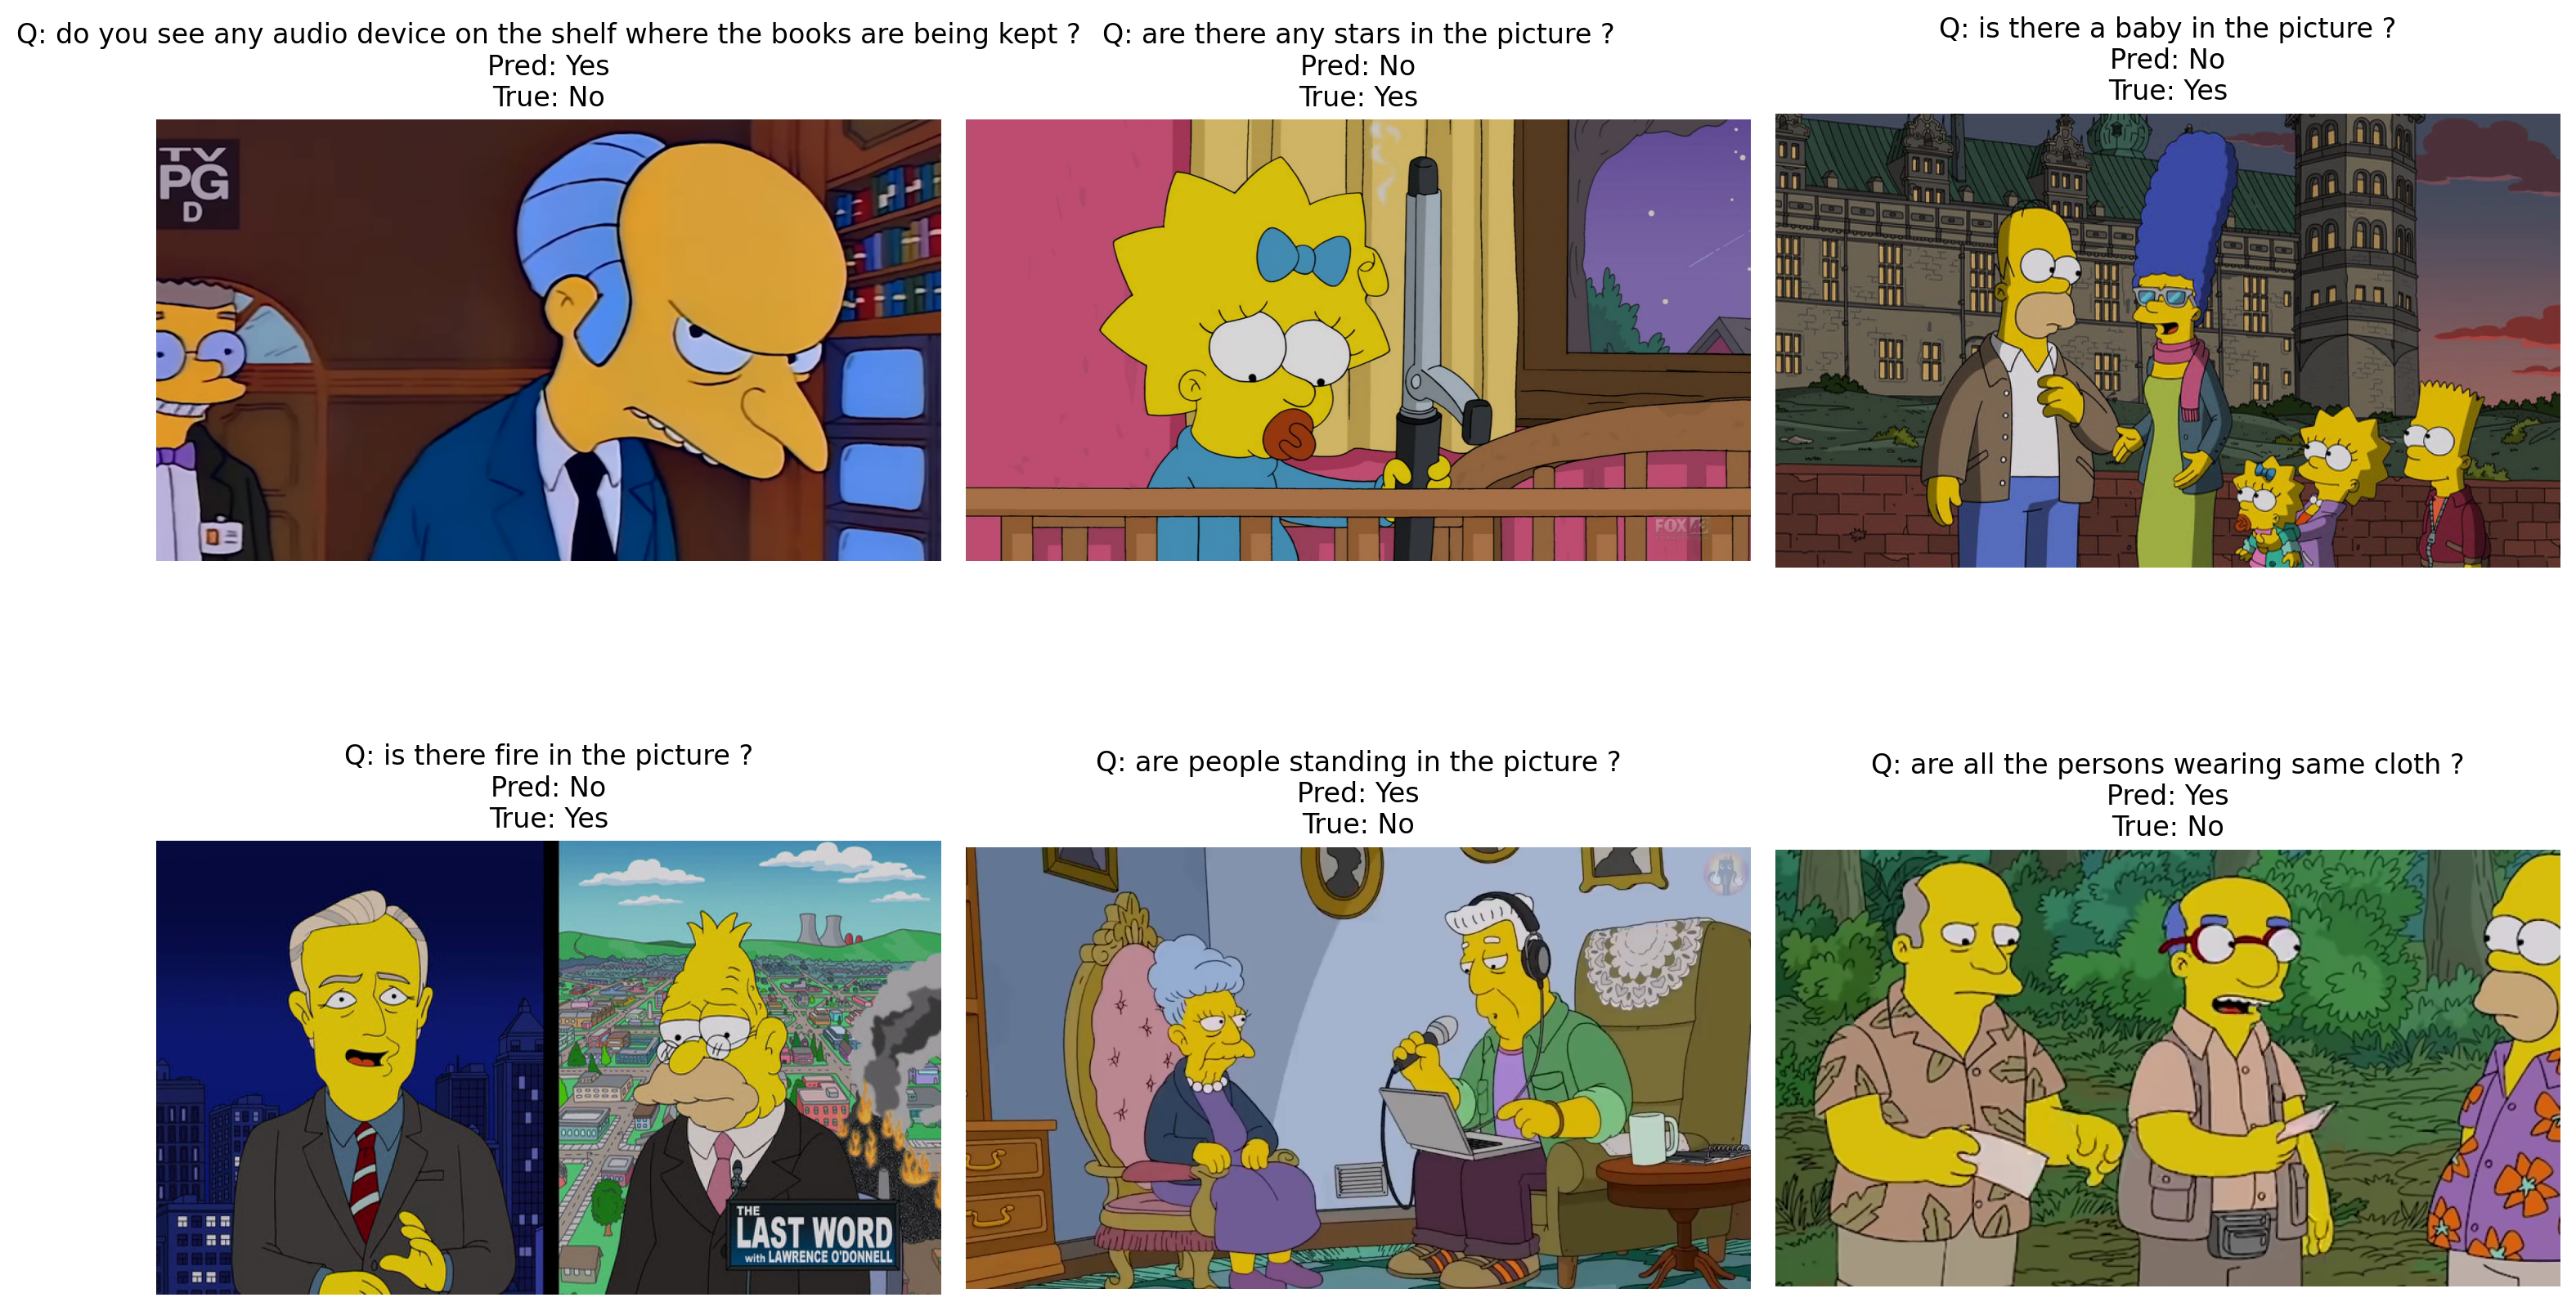

In [42]:
# Mapping dictionary
mapping_dict = {1: "Yes", 0: "No"}

results = pd.DataFrame({"Prediction": y_predict, 
                        "Correct": anno_val, 
                        "Image File": imgs_val,
                        "Question": q_val})

# Apply the mapping to 'Prediction' and 'Correct' columns
results['Prediction'] = results['Prediction'].map(mapping_dict)
results['Correct'] = results['Correct'].map(mapping_dict)

# Apply the mapping to 'Prediction' and 'Correct' columns
incorrect = results[results['Prediction'] != results['Correct']]

# Select 6 random incorrect predictions
incorrect_sample = incorrect.sample(n=6)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10), dpi=200)

# Flatten the 2D array 
axes = axes.flatten()

for i, ax in enumerate(axes[:6]):  
    row = incorrect_sample.iloc[i]
    img_path = row['Image File'] 
    img = np.array(Image.open(img_path))
    ax.imshow(img)
    ax.set_title(f"Q: {row['Question']}\nPred: {row['Prediction']}\nTrue: {row['Correct']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Save Final Model

In [ ]:
torch.save(model, 'model.pth')
wandb.save("model.pth")
art = wandb.Artifact(f'deakin-ai-vilt-final', type="model")
art.add_file("model.pth", "model.pth")
wandb.log_artifact(art)